In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
import pandas as pd
import cv2
from pyproj import Transformer
import rasterio
from rasterio.plot import show
import os

In [13]:
df = pd.read_csv('./data/lunar_crater_database_robbins_2018.csv')
columns = ['LAT_ELLI_IMG', 'LON_ELLI_IMG', 'DIAM_ELLI_MAJOR_IMG', 'DIAM_ELLI_MINOR_IMG', 'DIAM_ELLI_ANGLE_IMG']
# columns = ['LAT_CIRC_IMG', 'LON_CIRC_IMG', 'DIAM_CIRC_IMG']

df = df.loc[:, columns]
df.describe()

,LAT_ELLI_IMG,LON_ELLI_IMG,DIAM_ELLI_MAJOR_IMG,DIAM_ELLI_MINOR_IMG,DIAM_ELLI_ANGLE_IMG
count,1.296758e+06,1.296758e+06,1.296758e+06,1.296758e+06,1.296758e+06
mean,-1.316777e+00,1.664043e+02,2.604695e+00,2.280037e+00,8.662636e+01
std,4.356387e+01,9.680489e+01,5.787466e+00,5.234790e+00,3.956002e+01
min,-8.984790e+01,5.286540e-04,9.517580e-01,5.054060e-01,2.516500e-04
25%,-3.703428e+01,8.813560e+01,1.326442e+00,1.160680e+00,6.162833e+01
50%,-3.664035e+00,1.594170e+02,1.719435e+00,1.502360e+00,8.495685e+01
75%,3.326495e+01,2.386250e+02,2.553070e+00,2.228590e+00,1.102230e+02
max,8.997350e+01,3.600000e+02,2.612570e+03,2.373250e+03,1.800000e+02


In [14]:
# df = df[(df['LAT_CIRC_IMG'] >= 0) & (df['LAT_CIRC_IMG'] <= 60) & (df['LON_CIRC_IMG'] >= 180) & (df['LON_CIRC_IMG'] <= 270)]
df = df[(df['LAT_ELLI_IMG'] >= 0) & (df['LAT_ELLI_IMG'] <= 60) & (df['LON_ELLI_IMG'] >= 180) & (df['LON_ELLI_IMG'] <= 270)]
df

,LAT_ELLI_IMG,LON_ELLI_IMG,DIAM_ELLI_MAJOR_IMG,DIAM_ELLI_MINOR_IMG,DIAM_ELLI_ANGLE_IMG
3,1.95072,230.588,568.52900,546.37800,133.69100
21,13.90090,201.814,452.58600,414.20100,48.41660
24,39.50040,252.113,200.05400,164.58000,8.53708
27,51.13960,237.428,704.00600,574.91300,62.41420
133353,59.45960,180.518,11.24870,10.10970,87.82100
...,...,...,...,...,...
450247,37.82650,269.990,2.25274,1.89918,41.88760
450248,37.88020,269.987,2.12895,1.67874,83.51170
458757,24.39540,269.999,1.16927,1.00423,86.20200
462065,46.96700,213.672,15.84620,6.30281,166.06100


In [15]:
df.describe()

,LAT_ELLI_IMG,LON_ELLI_IMG,DIAM_ELLI_MAJOR_IMG,DIAM_ELLI_MINOR_IMG,DIAM_ELLI_ANGLE_IMG
count,143984.000000,143984.000000,143984.000000,143984.000000,143984.000000
mean,27.422730,222.018345,2.993969,2.604961,84.167862
std,16.790644,26.461913,5.551405,4.985388,35.185174
min,0.000061,180.001000,1.000560,0.640497,0.003672
25%,13.165325,198.553500,1.373928,1.191937,63.708175
50%,25.711000,220.154000,1.849495,1.598745,82.685350
75%,41.639000,245.476250,2.906753,2.520880,102.390000
max,59.999800,269.999000,704.006000,574.913000,179.998000


Metadata: {'driver': 'PDS', 'dtype': 'float32', 'nodata': -3.4028226550889045e+38, 'width': 27291, 'height': 18194, 'count': 1, 'crs': CRS.from_wkt('PROJCS["EQUIRECTANGULAR MOON",GEOGCS["GCS_MOON",DATUM["D_MOON",SPHEROID["MOON_localRadius",1737400,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Equirectangular"],PARAMETER["standard_parallel_1",0],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(100.0, 0.0, 5458200.0,
       0.0, -100.0, 1819400.0)}


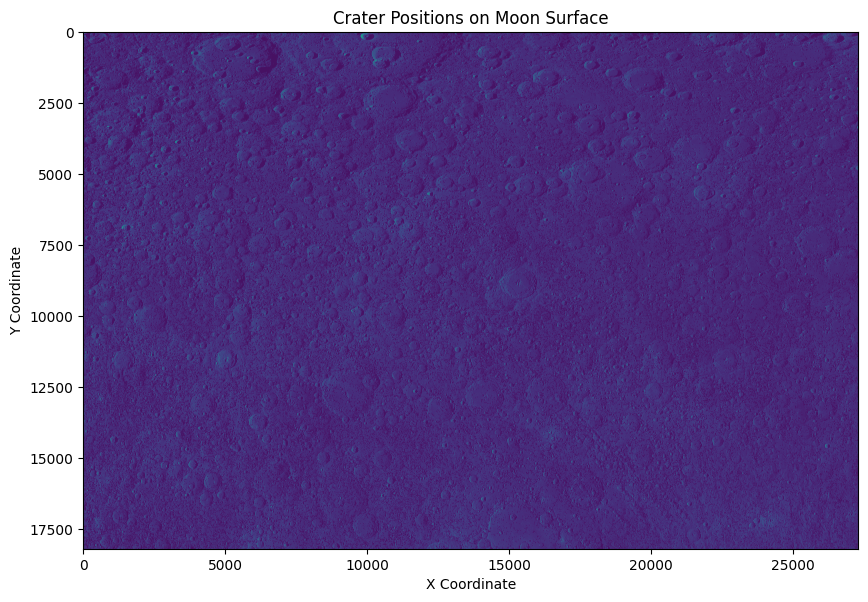

In [16]:


# Set the environment variable to ignore celestial body check
os.environ['PROJ_IGNORE_CELESTIAL_BODY'] = 'YES'

# Path to your image file
image_path = 'data/lro/WAC_GLOBAL_E300N2250_100M.IMG'

# Open the image with rasterio
with rasterio.open(image_path) as src:
    # Read the image data
    img_data = src.read(1)
    
    transform = src.transform
    crs = src.crs
    
    # Metadata for transformation
    transformer = Transformer.from_crs("EPSG:4326", crs, always_xy=True)  # WGS84 to Moon Equirectangular
    
    # Convert crater positions to the equirectangular projection
    crater_positions_projected = df.apply(
    lambda row: transformer.transform(row['LON_ELLI_IMG'], row['LAT_ELLI_IMG']), axis=1
    )
    
    # Convert projected coordinates to pixel coordinates using the affine transform
    crater_pixels = crater_positions_projected.apply(lambda pos: ~transform * pos)
    
    
    crater_pixels_df = pd.DataFrame(crater_pixels.tolist(), columns=['x', 'y'])
    
    df.reset_index(drop=True, inplace=True)
    crater_pixels_df.reset_index(drop=True, inplace=True)

    df = pd.concat([df, crater_pixels_df], axis=1)
    
    df = df[(df['x'] < 0)]
    
    min_x = df['x'].min()
    
    df['x'] = df['x'] - min_x
    
    # df = df[df['DIAM_ELLI_MAJOR_IMG'] >= 50]
    
    for row in df.itertuples():
        x = int(row.x)
        y = int(row.y)
        major = int(row.DIAM_ELLI_MAJOR_IMG*10/2)
        minor = int(row.DIAM_ELLI_MINOR_IMG*10/2)
        rotation = int(row.DIAM_ELLI_ANGLE_IMG)
        
        rotation = np.radians(rotation)
        cv2.ellipse(img_data, (x, y),
                        (major, minor),
                        angle=rotation, startAngle=0, endAngle=360,
                        color=(0, 255, 0), thickness=5)
    
    # Get the image metadata
    metadata = src.meta

    # Print the metadata
    print("Metadata:", metadata)

    plt.figure(figsize=(10, 10))
    plt.imshow(img_data)
    plt.title("Crater Positions on Moon Surface")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.show()

In [18]:
# df = df[df['DIAM_ELLI_MAJOR_IMG'] >= 50]

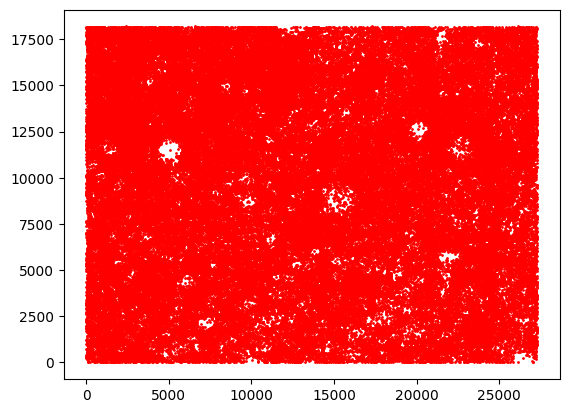

In [19]:
plt.scatter(df['x'], df['y'], c='red', s=1)

plt.show()

In [20]:
bl_corner_img = img_data[-5000:, :5000]

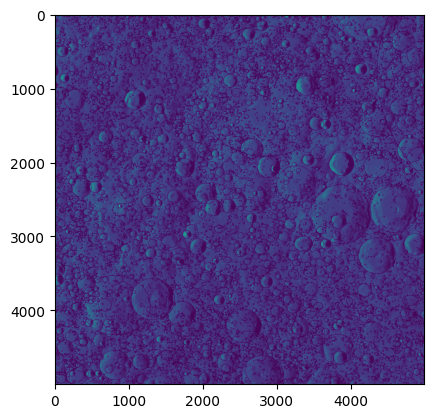

<Axes: >

In [21]:
show(bl_corner_img)

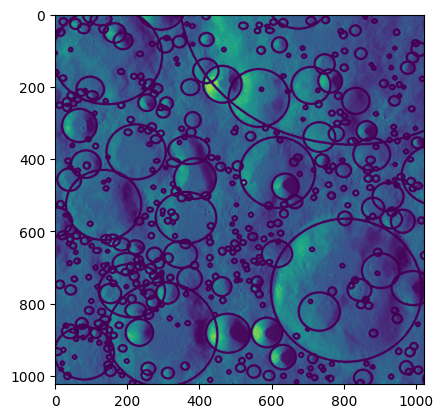

<Axes: >

In [22]:
bl_corner_img_2 = bl_corner_img[-1024:, :1024]
show(bl_corner_img_2)

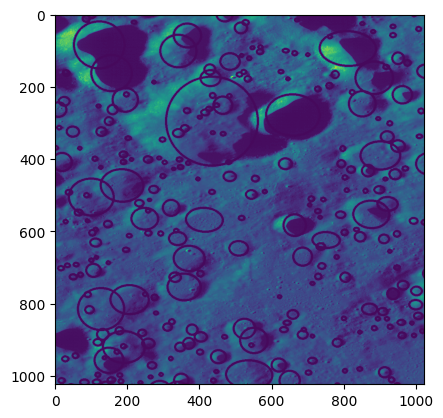

<Axes: >

In [23]:
bl_corner_img_3 = img_data[:1024, :1024]
show(bl_corner_img_3)

(5222, 506)


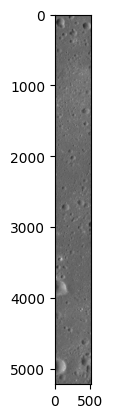

In [28]:
# Define image dimensions
height = 52224
width = 5064

# Load .IMG file
img_data = np.fromfile('data/lro/M1465577656LE.IMG', dtype=np.uint8)

# Calculate the expected size
expected_size = height * width

# Check if the data size matches the expected size
if img_data.size != expected_size:
    print(f"Warning: Data size ({img_data.size}) does not match expected size ({expected_size}). Trimming data.")
    img_data = img_data[img_data.size-expected_size:]

offset_left = 42
offset_right = 24
# Reshape array to image dimensions
img_data = img_data.reshape((height, width))
img_data = img_data[:, offset_left:-offset_right]

# img_data = np.fliplr(img_data)
img_data = np.flipud(img_data)

# Resize the image by half
img_data = cv2.resize(img_data, (width//10, height//10))

print(img_data.shape)
# Display the image
plt.imshow(img_data, cmap='gray')
plt.show()


In [29]:
image = Image.fromarray(img_data)

# Save the image as a file
image.save("M1465577656LE.jpg")

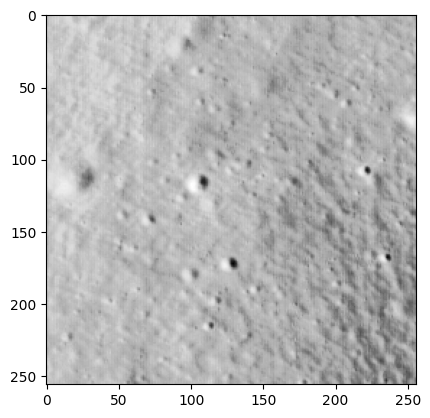

In [11]:
img_lt = Image.fromarray(img_data[:256, :256])

plt.imshow(img_lt, cmap='gray')
plt.show()

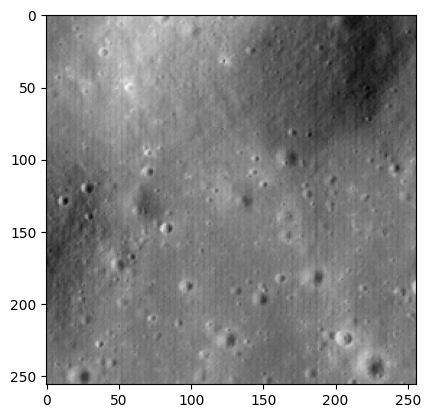

In [5]:
img_rt = Image.fromarray(img_data[:256, -256:])

plt.imshow(img_rt, cmap='gray')
plt.show()

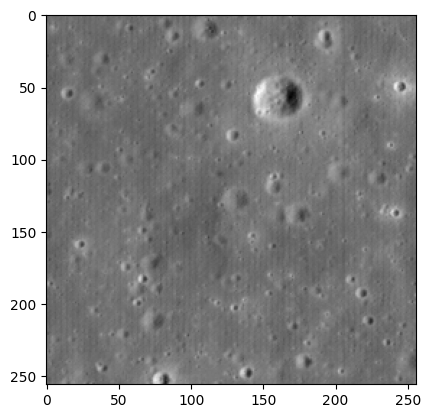

In [6]:
img_lb = Image.fromarray(img_data[-256:, :256])

plt.imshow(img_lb, cmap='gray')
plt.show()

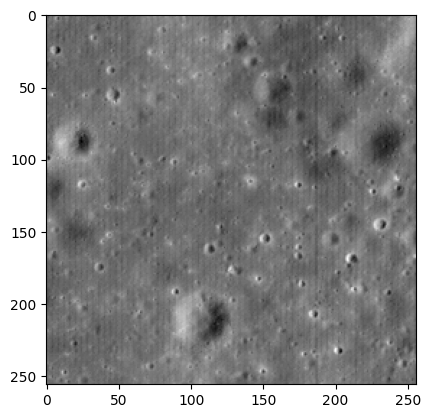

In [7]:
img_rb = Image.fromarray(img_data[-256:, -256:])

plt.imshow(img_rb, cmap='gray')
plt.show()

In [2]:

# Load the CSV file
df = pd.read_csv('./data/lunar_crater_database_robbins_2018.csv')
df.columns

Index(['CRATER_ID', 'LAT_CIRC_IMG', 'LON_CIRC_IMG', 'LAT_ELLI_IMG',
       'LON_ELLI_IMG', 'DIAM_CIRC_IMG', 'DIAM_CIRC_SD_IMG',
       'DIAM_ELLI_MAJOR_IMG', 'DIAM_ELLI_MINOR_IMG', 'DIAM_ELLI_ECCEN_IMG',
       'DIAM_ELLI_ELLIP_IMG', 'DIAM_ELLI_ANGLE_IMG', 'LAT_ELLI_SD_IMG',
       'LON_ELLI_SD_IMG', 'DIAM_ELLI_MAJOR_SD_IMG', 'DIAM_ELLI_MINOR_SD_IMG',
       'DIAM_ELLI_ANGLE_SD_IMG', 'DIAM_ELLI_ECCEN_SD_IMG',
       'DIAM_ELLI_ELLIP_SD_IMG', 'ARC_IMG', 'PTS_RIM_IMG'],
      dtype='object')

In [3]:
columns = ['LAT_CIRC_IMG', 'LON_CIRC_IMG', 'DIAM_CIRC_IMG', 'LAT_ELLI_IMG', 'LON_ELLI_IMG', 'DIAM_ELLI_MAJOR_IMG', 'DIAM_ELLI_MINOR_IMG', 'DIAM_ELLI_ANGLE_IMG']

df = df.loc[:, columns]
df

,LAT_CIRC_IMG,LON_CIRC_IMG,DIAM_CIRC_IMG,LAT_ELLI_IMG,LON_ELLI_IMG,DIAM_ELLI_MAJOR_IMG,DIAM_ELLI_MINOR_IMG,DIAM_ELLI_ANGLE_IMG
0,-19.83040,264.7570,940.96000,-19.89050,264.6650,975.87400,905.96800,35.99190
1,44.77630,328.6020,249.84000,44.40830,329.0460,289.44000,245.78600,127.00300
2,57.08660,82.0995,599.77800,56.90000,81.6464,632.57100,561.43500,149.16200
3,1.96124,230.6220,558.76200,1.95072,230.5880,568.52900,546.37800,133.69100
4,-49.14960,266.3470,654.33200,-49.18330,266.3530,665.24000,636.57800,87.64680
...,...,...,...,...,...,...,...,...
1296791,-65.62580,203.5000,5.93636,-65.62160,203.5380,7.05088,5.88898,3.11966
1296792,-60.02960,178.7090,7.82310,-60.03010,178.7120,8.31388,7.45470,72.80650
1296793,-66.79210,219.3790,11.55320,-66.79510,219.3470,13.98770,9.96860,41.71070
1296794,-79.83740,62.1794,7.16411,-79.84080,62.1830,7.31069,6.53201,8.53317


In [4]:
df.describe()

,LAT_CIRC_IMG,LON_CIRC_IMG,DIAM_CIRC_IMG,LAT_ELLI_IMG,LON_ELLI_IMG,DIAM_ELLI_MAJOR_IMG,DIAM_ELLI_MINOR_IMG,DIAM_ELLI_ANGLE_IMG
count,1.296796e+06,1.296796e+06,1.296796e+06,1.296758e+06,1.296758e+06,1.296758e+06,1.296758e+06,1.296758e+06
mean,-1.317424e+00,1.664051e+02,2.436963e+00,-1.316777e+00,1.664043e+02,2.604695e+00,2.280037e+00,8.662636e+01
std,4.356372e+01,9.680522e+01,5.519133e+00,4.356387e+01,9.680489e+01,5.787466e+00,5.234790e+00,3.956002e+01
min,-8.984790e+01,5.172670e-04,1.000000e+00,-8.984790e+01,5.286540e-04,9.517580e-01,5.054060e-01,2.516500e-04
25%,-3.703373e+01,8.813620e+01,1.242710e+00,-3.703428e+01,8.813560e+01,1.326442e+00,1.160680e+00,6.162833e+01
50%,-3.664890e+00,1.594180e+02,1.606840e+00,-3.664035e+00,1.594170e+02,1.719435e+00,1.502360e+00,8.495685e+01
75%,3.326443e+01,2.386270e+02,2.380860e+00,3.326495e+01,2.386250e+02,2.553070e+00,2.228590e+00,1.102230e+02
max,8.997350e+01,3.600000e+02,2.491870e+03,8.997350e+01,3.600000e+02,2.612570e+03,2.373250e+03,1.800000e+02


In [5]:

def translate_polygon(points):
    # Points A, B, C, D
    A, B, C, D = points
    
    # Calculate the vector AB (translation vector)
    translation_vector = np.array(A) - np.array(B)
    
    # Translate all points by the translation vector
    translated_points = [tuple(np.array(point) + translation_vector) for point in points]
    
    return translated_points

# Define the points A, B, C, D
points = [(0.94, 1.8), (0.82, 1.79), (0.94, 0.39), (1.07, 0.4)]

# Get the new translated points
translated_points = translate_polygon(points)

# Output the result
for i, point in enumerate(translated_points, start=1):
    print(f"Point {chr(64+i)}': {point}")


Point A': (np.float64(1.06), np.float64(1.81))
Point B': (np.float64(0.94), np.float64(1.8))
Point C': (np.float64(1.06), np.float64(0.4))
Point D': (np.float64(1.19), np.float64(0.41000000000000003))


In [9]:
west = min(translated_points, key=lambda point: point[0])[0]
east = max(translated_points, key=lambda point: point[0])[0]
south = min(translated_points, key=lambda point: point[1])[1]
north = max(translated_points, key=lambda point: point[1])[1]

west, east, south, north

(np.float64(0.94), np.float64(1.19), np.float64(0.4), np.float64(1.81))

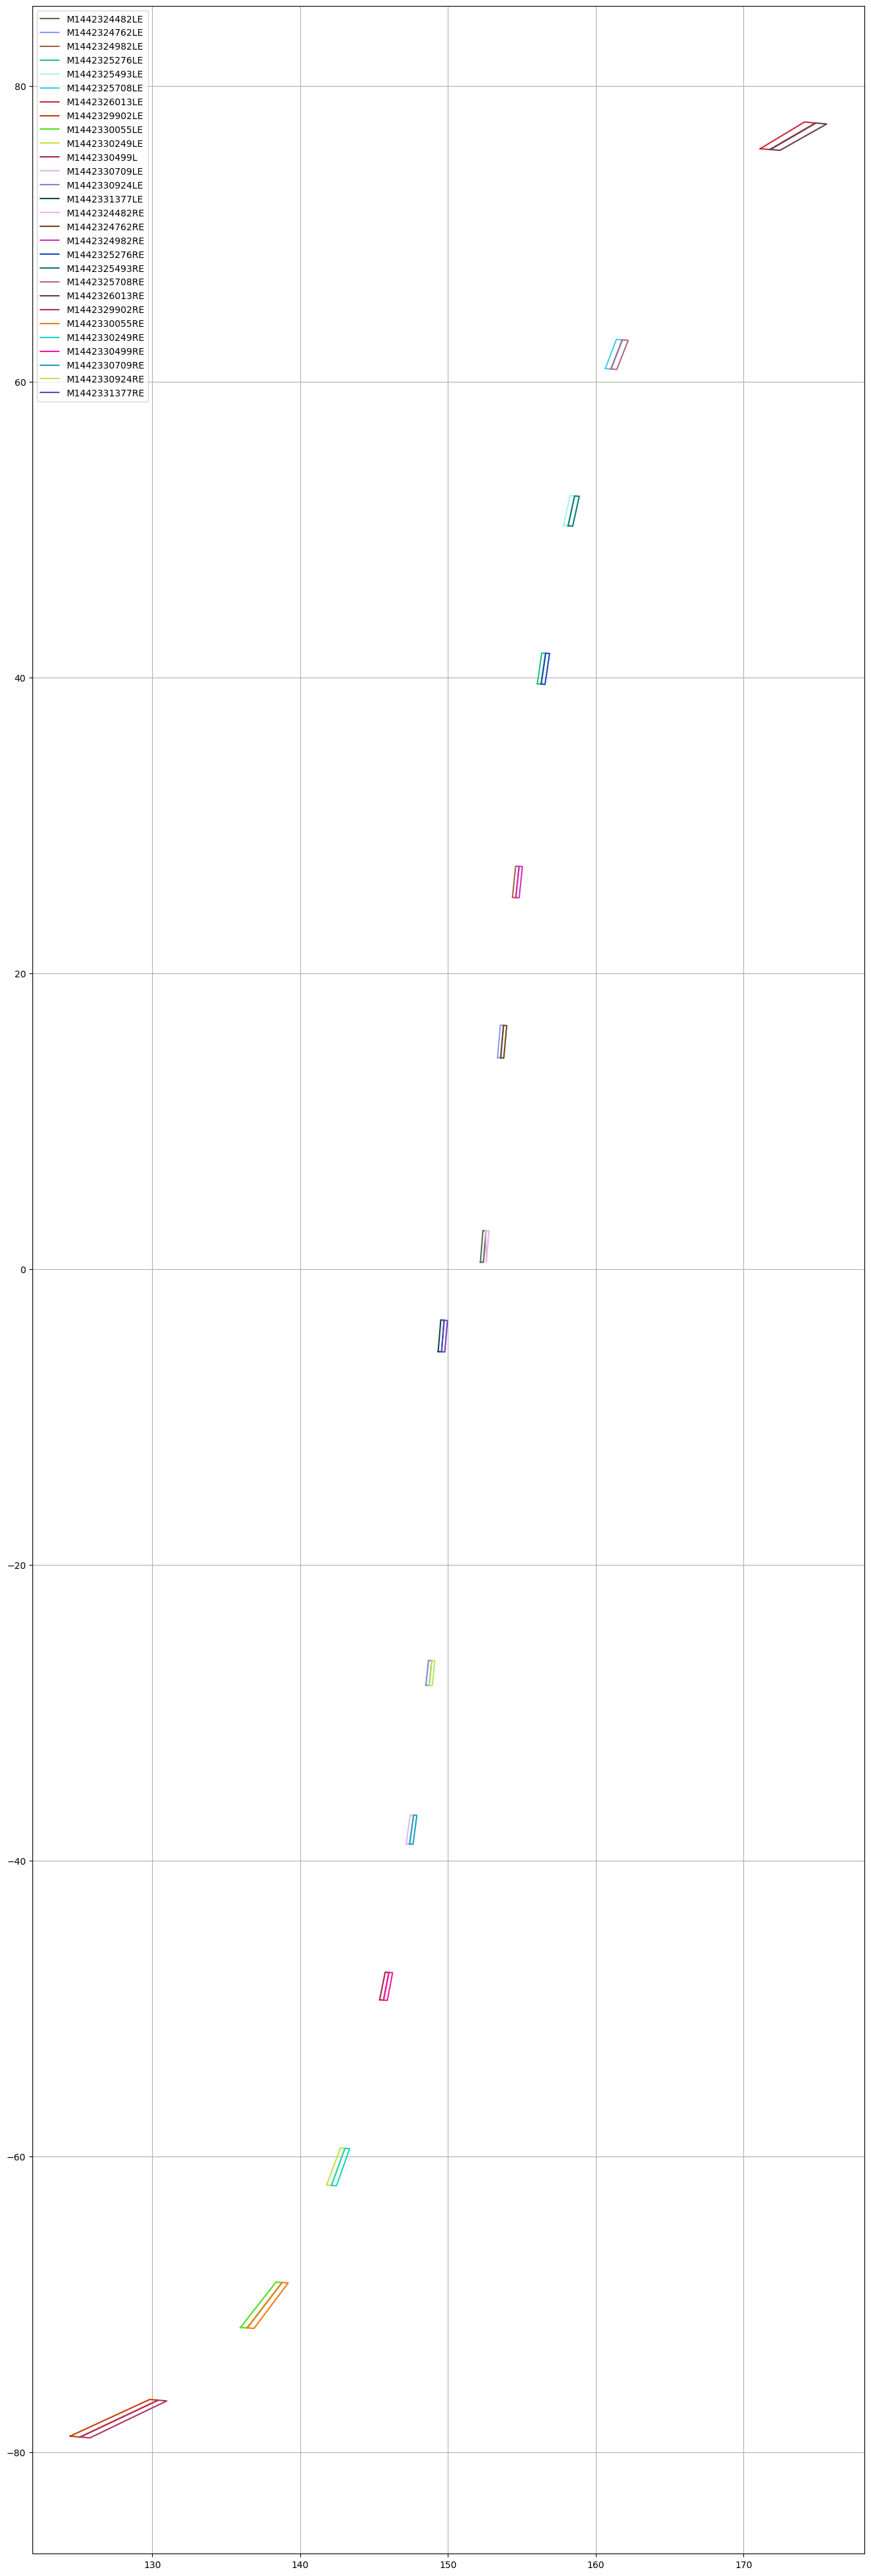

In [5]:
# List of vertices for all polygons
polygon_vertices = [
    # (lon, lat)
    # #63001
    # ([(151.58, 5.91), (151.79, 5.89), (151.97, 8.04), (151.76, 8.06)], "M1442331613LE"), #[(Upper left longitude, Upper left latitude), (Upper right longitude, Upper right latitude), (Lower right longitude, Lower right latitude), (Lower left longitude, Lower left latitude)]
    # ([(152.54, 17.04), (152.76, 17.02), (152.96, 19.17), (152.74, 19.19)], "M1442331839LE"),
    # ([(153.66, 28.57), (153.9, 28.55), (154.14, 30.7), (153.9, 30.72)], "M1442332073LE"),
    # ([(154.96, 39.35), (155.23, 39.33), (155.53, 41.41), (155.26, 41.44)], "M1442332292LE"),
    # ([(156.74, 50.05), (157.04, 50.03), (157.49, 52.09), (157.17, 52.12)], "M1442332509LE"),
    # ([(159.55, 60.72), (159.94, 60.69), (160.7, 62.66), (160.29, 62.7)], "M1442332725LE"),
    # ([(170.69, 76.13), (171.39, 76.07), (174.65, 77.85), (173.88, 77.92)], "M1442333042LE"),
    # ([(123.27, -78.94), (123.94, -79.0), (129.25, -76.51), (128.67, -76.46)], "M1442336922LE"),
    # ([(134.84, -71.59), (135.3, -71.63), (137.68, -68.56), (137.27, -68.52)], "M1442337075LE"),
    # ([(142.0, -58.35), (142.31, -58.38), (143.19, -55.34), (142.9, -55.31)], "M1442337340LE"),
    # ([(144.49, -48.51), (144.75, -48.53), (145.1, -46.68), (144.84, -46.66)], "M1442337537LE"),
    # ([(146.23, -38.01), (146.46, -38.03), (146.71, -36.15), (146.48, -36.13)], "M1442337747LE"),
    # ([(146.85, -23.94), (147.08, -23.96), (147.29, -21.92), (147.06, -21.9)], "M1442338028LE"), #3
    # ([(148.89, -13.34), (149.09, -13.36), (149.21, -11.95), (149.01, -11.93)], "M1442338243LE"),
    # ([(149.54, -5.73), (149.74, -5.75), (149.93, -3.59), (149.72, -3.58)], "M1442338397LE"), #5
    #63000
    ([(152.2, 0.46), (152.4, 0.44), (152.58, 2.58), (152.37, 2.59)], "M1442324482LE"),
    ([(153.36, 14.29), (153.57, 14.27), (153.77, 16.46), (153.55, 16.48)], "M1442324762LE"),
    ([(154.37, 25.12), (154.6, 25.1), (154.82, 27.21), (154.58, 27.23)], "M1442324982LE"),
    ([(156.05, 39.56), (156.31, 39.54), (156.62, 41.62), (156.35, 41.65)], "M1442325276LE"),
    ([(157.83, 50.26), (158.14, 50.24), (158.58, 52.26), (158.26, 52.29)], "M1442325493LE"),
    ([(160.65, 60.88), (161.04, 60.84), (161.81, 62.81), (161.4, 62.85)], "M1442325708LE"),
    ([(171.13, 75.74), (171.81, 75.68), (174.89, 77.47), (174.13, 77.55)], "M1442326013LE"),
    ([(124.45, -78.92), (125.12, -78.99), (130.41, -76.49), (129.83, -76.44)], "M1442329902LE"),
    ([(135.97, -71.57), (136.43, -71.61), (138.79, -68.54), (138.38, -68.5)], "M1442330055LE"),
    ([(141.8, -61.94), (142.13, -61.97), (143.04, -59.47), (142.73, -59.44)], "M1442330249LE"),
    ([(145.38, -49.42), (145.65, -49.44), (146.01, -47.57), (145.76, -47.55)], "M1442330499L"),
    ([(147.18, -38.88), (147.42, -38.9), (147.68, -36.94), (147.45, -36.92)], "M1442330709LE"),
    ([(148.51, -28.15), (148.73, -28.17), (148.91, -26.49), (148.69, -26.47)], "M1442330924LE"),
    ([(149.34, -5.59), (149.57, -5.61), (149.75, -3.47), (149.52, -3.45)], "M1442331377LE"), #1

    #63000R
    ([(152.57, 2.58), (152.6, 0.43), (152.78, 2.57), (152.57, 2.58)], "M1442324482RE"),
    ([(153.57, 14.27), (153.78, 14.26), (153.98, 16.45), (153.76, 16.47)], "M1442324762RE"),
    ([(154.59, 25.11), (154.82, 25.09), (155.04, 27.2), (154.81, 27.22)], "M1442324982RE"),
    ([(156.31, 39.55), (156.57, 39.52), (156.88, 41.61), (156.61, 41.63)], "M1442325276RE"),
    ([(158.13, 50.24), (158.44, 50.22), (158.89, 52.24), (158.57, 52.26)], "M1442325493RE"),
    ([(161.03, 60.85), (161.42, 60.81), (162.2, 62.78), (161.79, 62.82)], "M1442325708RE"),
    ([(171.79, 75.69), (172.47, 75.63), (175.62, 77.41), (174.87, 77.48)], "M1442326013RE"),
    ([(125.11, -78.98), (125.78, -79.04), (130.98, -76.54), (130.39, -76.49)], "M1442329902RE"),
    ([(136.41, -71.6), (136.88, -71.64), (139.19, -68.57), (138.78, -68.53)], "M1442330055RE"),
    ([(142.12, -61.97), (142.46, -62.0), (143.35, -59.49), (143.03, -59.46)], "M1442330249RE"),
    ([(145.64, -49.44), (145.9, -49.46), (146.26, -47.59), (146.01, -47.56)], "M1442330499RE"),
    ([(147.41, -38.89), (147.64, -38.91), (147.9, -36.95), (147.68, -36.93)], "M1442330709RE"),
    ([(148.72, -28.16), (148.94, -28.18), (149.12, -26.5), (148.9, -26.48)], "M1442330924RE"),
    ([(149.57, -5.6), (149.79, -5.62), (149.97, -3.49), (149.74, -3.47)], "M1442331377RE"), #6

    # #63002
    # ([(150.49, 5.69), (150.7, 5.67), (150.88, 7.82), (150.68, 7.84)], "M1442338629LE"),
    # ([(152.02, 22.88), (152.25, 22.86), (152.47, 25.06), (152.24, 25.08)], "M1442338978LE"),
    # ([(153.18, 33.73), (153.43, 33.71), (153.7, 35.84), (153.44, 35.86)], "M1442339198LE"),
    # ([(154.68, 44.49), (154.96, 44.47), (155.33, 46.6), (155.04, 46.62)], "M1442339416LE"),
    # ([(156.87, 55.25), (157.21, 55.22), (157.77, 57.24), (157.42, 57.28)], "M1442339635LE"),
    # ([(168.83, 75.56), (169.51, 75.5), (172.52, 77.29), (171.77, 77.36)], "M1442340050LE"),
    # ([(330.3, -5.73), (330.21, -5.74), (330.21, -5.78), (330.31, -5.77)], "M1442342157LE"),
    # ([(122.18, -78.92), (122.85, -78.98), (128.16, -76.49), (127.58, -76.44)], "M1442343943LE"),
    # ([(133.74, -71.58), (134.2, -71.62), (136.31, -68.95), (135.89, -68.91)], "M1442344096LE"),
    # ([(140.04, -60.84), (140.37, -60.87), (141.37, -57.89), (141.07, -57.86)], "M1442344311LE"),
    # ([(142.74, -51.6), (143.01, -51.63), (143.4, -49.82), (143.14, -49.8)], "M1442344496LE"),
    # ([(144.91, -39.69), (145.14, -39.71), (145.42, -37.76), (145.19, -37.73)], "M1442344734LE"),
    # ([(146.53, -26.57), (146.75, -26.59), (146.94, -24.78), (146.72, -24.76)], "M1442344997LE"),
    # ([(149.32, -5.59), (149.54, -5.61), (149.72, -3.48), (149.5, -3.46)], "M1442345422LE"), #2

    # # 63003
    # ([(149.39, 5.28), (149.6, 5.27), (149.78, 7.37), (149.57, 7.39)], "M1442345641LE"),
    # ([(150.69, 20.06), (150.91, 20.04), (151.11, 22.17), (150.89, 22.19)], "M1442345941LE"),
    # ([(152.22, 34.52), (152.47, 34.49), (152.74, 36.62), (152.49, 36.65)], "M1442346234LE"),
    # ([(153.75, 45.28), (154.03, 45.25), (154.42, 47.38), (154.12, 47.41)], "M1442346453LE"),
    # ([(156.02, 56.04), (156.37, 56.01), (156.96, 58.03), (156.6, 58.06)], "M1442346671LE"),
    # ([(167.81, 75.56), (168.49, 75.5), (171.5, 77.29), (170.75, 77.36)], "M1442347071LE"),
    # ([(121.05, -78.91), (121.72, -78.98), (127.04, -76.49), (126.46, -76.43)], "M1442350963LE"),
    # ([(132.63, -71.57), (133.09, -71.62), (135.25, -68.88), (134.84, -68.84)], "M1442351116LE"),
    # ([(138.67, -61.56), (139.0, -61.59), (140.2, -58.14), (139.9, -58.11)], "M1442351317LE"),
    # ([(141.72, -51.32), (141.99, -51.34), (142.38, -49.51), (142.12, -49.49)], "M1442351522LE"),
    # ([(143.66, -40.84), (143.89, -40.86), (144.16, -38.99), (143.93, -38.97)], "M1442351732LE"),
    # ([(146.87, -23.95), (147.1, -23.97), (147.29, -21.93), (147.07, -21.91)], "M1442352073LE"), #4
    # ([(146.76, -13.12), (146.96, -13.14), (147.14, -11.09), (146.94, -11.07)], "M1442352289LE")
]

fig, ax = plt.subplots(figsize=(50, 50))

import random
# Create and plot polygons using a loop
for i, vertices in enumerate(polygon_vertices):
    polygon = Polygon(vertices[0])
    label = vertices[1]
    x, y = polygon.exterior.xy
    random_color = [random.random() for _ in range(3)]  # Generate a random RGB color
    ax.plot(x, y, color=random_color, label=label)

# Add a legend
ax.legend()

# Add grid lines and set aspect ratio
ax.grid(True)
plt.gca().set_aspect('equal', adjustable='box')

# Show the plot
plt.show()


In [3]:
def calculate_iou(polygon1, polygon2):
    poly1 = Polygon(polygon1)
    poly2 = Polygon(polygon2)
    
    # Calculate intersection and union
    intersection = poly1.intersection(poly2).area
    union = poly1.union(poly2).area
    
    # IoU is the ratio of intersection area over union area
    iou = intersection / union if union != 0 else 0
    return iou

def find_overlapping_polygons(polygon_vertices, threshold=0.3):
    overlaps = []
    
    for i in range(len(polygon_vertices)):
        polygon1, name1 = polygon_vertices[i]
        
        for j in range(i+1, len(polygon_vertices)):
            polygon2, name2 = polygon_vertices[j]
            
            iou = calculate_iou(polygon1, polygon2)
            
            if iou > threshold:
                overlaps.append((name1, name2, iou))
    
    return overlaps

In [4]:
overlapping_polygons = find_overlapping_polygons(polygon_vertices, threshold=0.5)
overlapping_polygons

[('M1442338028LE', 'M1442352073LE', 0.8815978950280599),
 ('M1442338397LE', 'M1442331377RE', 0.7167259650686467),
 ('M1442331377LE', 'M1442345422LE', 0.7994277436355115)]

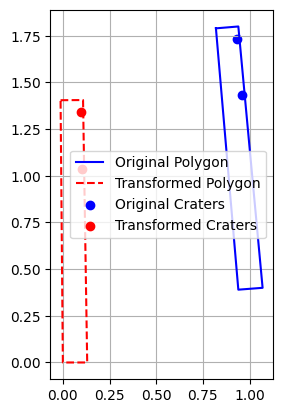

In [12]:

polygon_width = np.sqrt((polygon_vertices[0][0] - polygon_vertices[1][0])**2 + (polygon_vertices[0][1] - polygon_vertices[1][1])**2)
polygon_height = np.sqrt((polygon_vertices[1][0] - polygon_vertices[2][0])**2 + (polygon_vertices[1][1] - polygon_vertices[2][1])**2)

# Define the lower-left point
lower_left_point = np.array(polygon_vertices[3])
# Define the lower-right point
lower_right_point = np.array(polygon_vertices[2])

# Translation matrix to move lower-left point to the origin
translation_matrix = np.array([
    [1, 0, -lower_left_point[0]],
    [0, 1, -lower_left_point[1]],
    [0, 0, 1]
])

# Calculate the angle to rotate the polygon
delta_x = lower_right_point[0] - lower_left_point[0]
delta_y = lower_right_point[1] - lower_left_point[1]
theta = np.arctan2(delta_y, delta_x)

# Rotation matrix to align the vertical line with the y-axis
rotation_matrix = np.array([
    [np.cos(-theta), -np.sin(-theta), 0],
    [np.sin(-theta), np.cos(-theta), 0],
    [0, 0, 1]
])

# Combined transformation matrix
transformation_matrix = rotation_matrix @ translation_matrix 

# Transform the polygon vertices
def apply_transformation(point, matrix):
    homogeneous_point = np.array([point[0], point[1], 1])
    transformed_point = matrix @ homogeneous_point
    
    return (transformed_point[0], transformed_point[1])

original_craters_x = filtered_df['LON_ELLI_IMG']
original_craters_y = filtered_df['LAT_ELLI_IMG']

transformed_craters = [apply_transformation((x, y), transformation_matrix) for x, y in zip(original_craters_x, original_craters_y)]
transformed_vertices = [apply_transformation(vertex, transformation_matrix) for vertex in polygon_vertices]

# Create shapely Polygon objects
original_polygon = Polygon(polygon_vertices)
transformed_polygon = Polygon(transformed_vertices)

# Plot the original and transformed polygons
fig, ax = plt.subplots()

# Plot original polygon
x, y = original_polygon.exterior.xy
ax.plot(x, y, label='Original Polygon', color='blue')

# Plot transformed polygon
x, y = transformed_polygon.exterior.xy
ax.plot(x, y, label='Transformed Polygon', color='red', linestyle='--')

# Plot the original craters
ax.scatter(original_craters_x, original_craters_y, color='blue', marker='o', label='Original Craters')

# Plot the transformed craters
transformed_craters_x, transformed_craters_y = zip(*transformed_craters)
ax.scatter(transformed_craters_x, transformed_craters_y, color='red', marker='o', label='Transformed Craters')

# Set aspect ratio
plt.gca().set_aspect('equal', adjustable='box')

# Add a legend
ax.legend()

# Add grid
ax.grid(True)

# Show the plot
plt.show()


In [182]:
transformed_craters

[(np.float64(0.09559029790249762), np.float64(1.339353644401624)),
 (np.float64(0.10175508578635406), np.float64(1.0388657352615938))]

In [163]:
img_data.shape

(26112, 2532)

In [192]:
scale_factor_y = img_data.shape[0] / polygon_height
scale_factor_y

np.float64(18571.53436891585)

In [168]:
scale_factor_x = img_data.shape[1] / polygon_width
scale_factor_x

np.float64(21027.115498966963)

In [183]:
transformed_craters

[(np.float64(0.09559029790249762), np.float64(1.339353644401624)),
 (np.float64(0.10175508578635406), np.float64(1.0388657352615938))]

In [218]:
final_img = img_data.copy()
for i in transformed_craters:
    point_x, point_y = i
    x = int(point_x*scale_factor_x)
    y = int(img_data.shape[0] - point_y*scale_factor_y)
    print(x, y)
    cv2.circle(final_img, (x, y), radius=100, color=(255, 255, 255), thickness=-1)


2009 1238
2139 6818


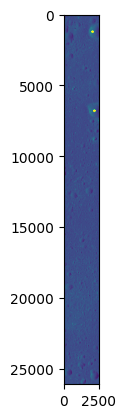

In [219]:
plt.imshow(final_img)

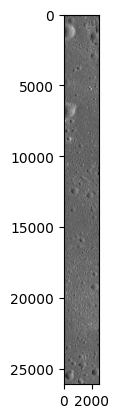

In [136]:
import cv2


src_shape = img_data.shape

# Resize the target image to a smaller size
target_img_resized = cv2.resize(img_data, (src_shape[1]//2, src_shape[0]//2))

plt.imshow(target_img_resized, cmap='gray')
plt.show()

In [131]:
filtered_df

,LAT_CIRC_IMG,LON_CIRC_IMG,DIAM_CIRC_IMG,LAT_ELLI_IMG,LON_ELLI_IMG,DIAM_ELLI_MAJOR_IMG,DIAM_ELLI_MINOR_IMG,DIAM_ELLI_ANGLE_IMG
562193,1.73277,0.932726,1.65217,1.73274,0.932585,1.71968,1.59330,106.322
562197,1.43358,0.961759,1.80851,1.43361,0.961778,1.88434,1.73084,140.175


In [129]:
list(zip(filtered_df['LON_ELLI_IMG'], filtered_df['LAT_ELLI_IMG']))

[(0.932585, 1.73274), (0.961778, 1.43361)]

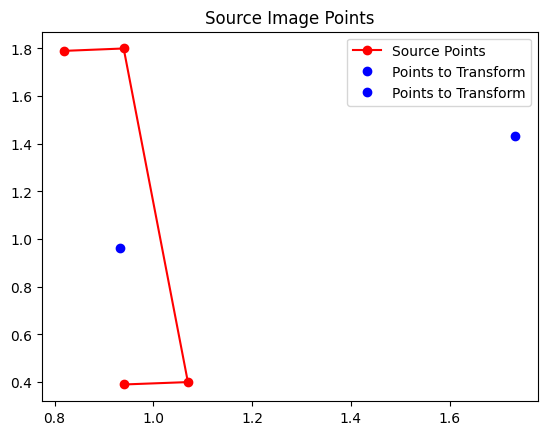

In [144]:
source_points = np.array(polygon_vertices, dtype=np.float32)
target_points = np.array([(target_img_resized_shape[1], target_img_resized_shape[0]), (0, target_img_resized_shape[0]), (0, 0), (target_img_resized_shape[1], 0)], dtype=np.float32)

# Estimate the perspective transformation matrix (M)
M = cv2.getPerspectiveTransform(source_points, target_points)

# Points in the source image
source_points_to_transform = np.array([list(zip(filtered_df['LON_ELLI_IMG'], filtered_df['LAT_ELLI_IMG']))], dtype=np.float32)

# Transform the points to get their corresponding points in the target image
target_points_transformed = cv2.perspectiveTransform(source_points_to_transform.reshape(-1, 1, 2), M)

# Plotting
plt.figure(figsize=(10, 5))

# Plot points in the source image
plt.subplot(1, 2, 1)
plt.plot(source_points[:, 0], source_points[:, 1], 'ro-', label='Source Points')
plt.plot(source_points_to_transform[:, 0], source_points_to_transform[:, 1], 'bo', label='Points to Transform')
plt.title('Source Image Points')
plt.xlim(-50, 200)
plt.ylim(-50, 200)
plt.legend()

# Plot corresponding points in the target image
plt.subplot(1, 2, 2)
plt.plot(target_points[:, 0], target_points[:, 1], 'go-', label='Target Points')
plt.plot(target_points_transformed[:, 0, 0], target_points_transformed[:, 0, 1], 'bo', label='Transformed Points')
plt.title('Target Image Points (Transformed)')
plt.xlim(-50, 200)
plt.ylim(-50, 200)
plt.legend()

plt.tight_layout()
plt.show()


In [14]:
image_1 = cv2.imread('./framw_0_strip_1.jpg', cv2.IMREAD_GRAYSCALE)
image_2 = cv2.imread("./framw_2_strip_2.jpg", cv2.IMREAD_GRAYSCALE)

In [19]:
combined_image = np.hstack((image_1, image_2))

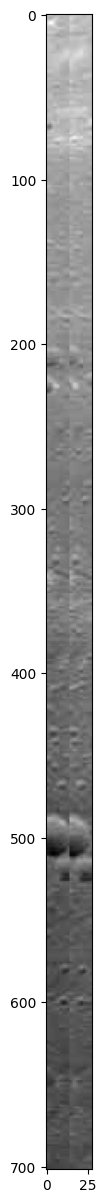

In [21]:
plt.figure(figsize=(15,15))
plt.imshow(combined_image, 'gray')
plt.show()

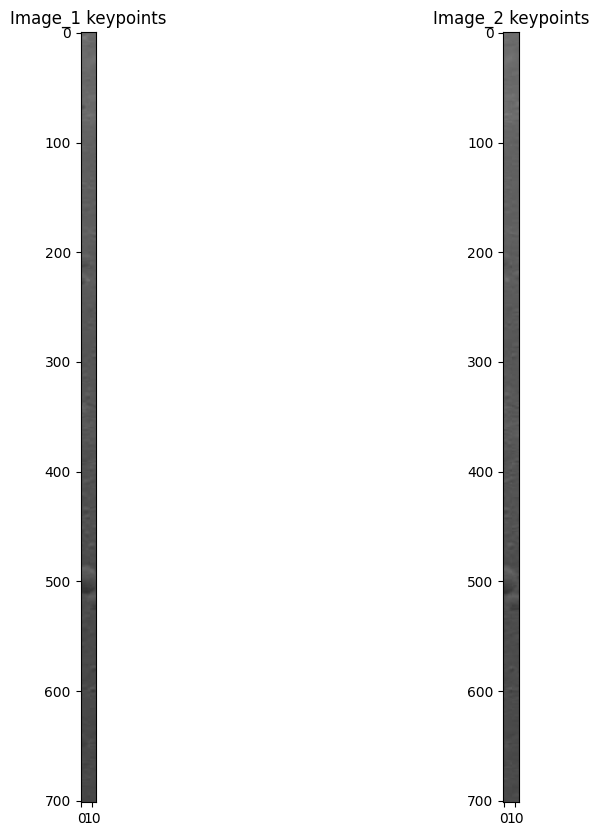

In [22]:
#Display keypoints for both images using ORB
orb = cv2.SIFT_create(nfeatures=1000, edgeThreshold=5)

keypoints_1, descriptors_1 = orb.detectAndCompute(image_1, None)
keypoints_2, descriptors_2 = orb.detectAndCompute(image_2, None)

out_image_2 = np.copy(image_2)
out_image_1 = np.copy(image_1)

out_image_2 = cv2.drawKeypoints(image_2, keypoints_2, out_image_2, color = (0, 255, 0))

out_image_1 = cv2.drawKeypoints(image_1, keypoints_1, out_image_1, color = (0, 255, 0))

fx, plots = plt.subplots(1, 2, figsize=(10,10))
plots[0].set_title("Image_1 keypoints")
plots[0].imshow(out_image_1, cmap='gray')

plots[1].set_title("Image_2 keypoints")
plots[1].imshow(out_image_2, cmap='gray')

In [13]:
keypoints_1

()

In [39]:
def find_and_draw_good_matches(image_1, image_2, keypoints_1, keypoints_2, matches, ratio, is_plot=True):
    """
    Find and draw good matches between reference and query images.

    Args:
        image_1 (numpy.ndarray): Reference image.
        image_2 (numpy.ndarray): Query image.
        ref_keypoints (list): List of keypoints in the reference image.
        query_keypoints (list): List of keypoints in the query image.
        matches (list): List of matches between keypoints.
        ratio (float): Ratio threshold for the ratio test.
        is_plot (bool, optional): Whether to display the matches plot. Defaults to True.

    Returns:
        list: List of good matches.

    """
    # Apply ratio test to find good matches
    good_matches = []
    for higher_match, lower_match in matches:
        if higher_match.distance < ratio * lower_match.distance:
            good_matches.append(higher_match)
    print(f"Number of good matches: {len(good_matches)}")

    # Draw matches
    img_matches = cv2.drawMatches(image_1, keypoints_1, image_2, keypoints_2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    if not is_plot:
        return good_matches
    else: 
        # Display the matches
        plt.figure(figsize=(10, 10))
        plt.imshow(img_matches)
        plt.title(f'Good Matches (ratio={ratio})')
        plt.axis('off')
        plt.show()
        return good_matches

In [40]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING)

#knnMatch will return 2 best matches for each descriptor, later we will filter that using ratio test
matches = bf.knnMatch(descriptors_1, descriptors_2, k=2) 
matches

((< cv2.DMatch 0x7fece7eaa5f0>, < cv2.DMatch 0x7fece8078770>),
 (< cv2.DMatch 0x7fed574c5e70>, < cv2.DMatch 0x7fece80d3c70>),
 (< cv2.DMatch 0x7fed3d1f7850>, < cv2.DMatch 0x7fed3d1f79b0>),
 (< cv2.DMatch 0x7fed3d1f7cd0>, < cv2.DMatch 0x7fed3d1f7950>),
 (< cv2.DMatch 0x7fed3d1f7ab0>, < cv2.DMatch 0x7fed3d074870>),
 (< cv2.DMatch 0x7fed3d0742b0>, < cv2.DMatch 0x7fed3d0746b0>),
 (< cv2.DMatch 0x7fed3d074270>, < cv2.DMatch 0x7fed3d074cd0>),
 (< cv2.DMatch 0x7fed3d074890>, < cv2.DMatch 0x7fed3d074810>),
 (< cv2.DMatch 0x7fed3d074250>, < cv2.DMatch 0x7fed3d0748b0>),
 (< cv2.DMatch 0x7fed3d074670>, < cv2.DMatch 0x7fed3d0746f0>),
 (< cv2.DMatch 0x7fed3d0745b0>, < cv2.DMatch 0x7fed3d074610>),
 (< cv2.DMatch 0x7fed3d074710>, < cv2.DMatch 0x7fed3d074910>),
 (< cv2.DMatch 0x7fed3d074430>, < cv2.DMatch 0x7fed3d074690>),
 (< cv2.DMatch 0x7fed3d074290>, < cv2.DMatch 0x7fed3d074790>),
 (< cv2.DMatch 0x7fed3d074eb0>, < cv2.DMatch 0x7fed3d074d30>),
 (< cv2.DMatch 0x7fed3d074550>, < cv2.DMatch 0x7fed3d07

Number of good matches: 105


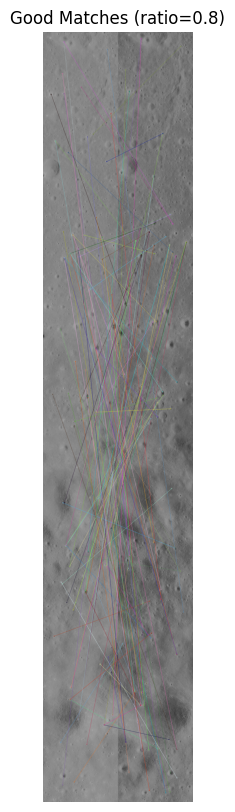

In [57]:
good_matches = find_and_draw_good_matches(image_2, image_1, keypoints_2, keypoints_1, matches, 0.8)

In [58]:
src = np.float32([keypoints_1[m.queryIdx].pt for m in good_matches]).reshape(-1,1,2)
dst = np.float32([keypoints_2[m.trainIdx].pt for m in good_matches]).reshape(-1,1,2)
H, masked = cv2.findHomography(src, dst, cv2.RANSAC, 5.0)


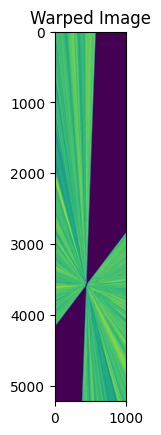

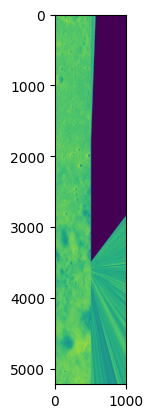

In [59]:
dst = cv2.warpPerspective(image_1,H,(image_2.shape[1] + image_1.shape[1], image_2.shape[0]))
plt.subplot(122)
plt.imshow(dst)
plt.title('Warped Image')
plt.show()
plt.figure()
dst[0:image_2.shape[0], 0:image_2.shape[1]] = image_2
cv2.imwrite('output.jpg',dst)
plt.imshow(dst)
plt.show()

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load reference (template) and moving images
reference_image = cv2.imread("image_1.jpg", 0)  # Template (reference) image, grayscale
moving_image = cv2.imread("image_2.jpg", 0)  # Moving image, grayscale

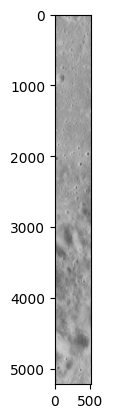

In [7]:
plt.imshow(reference_image, cmap='gray')

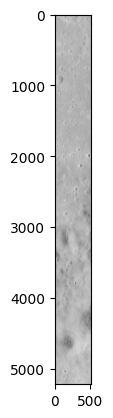

In [8]:
plt.imshow(moving_image, cmap='gray')

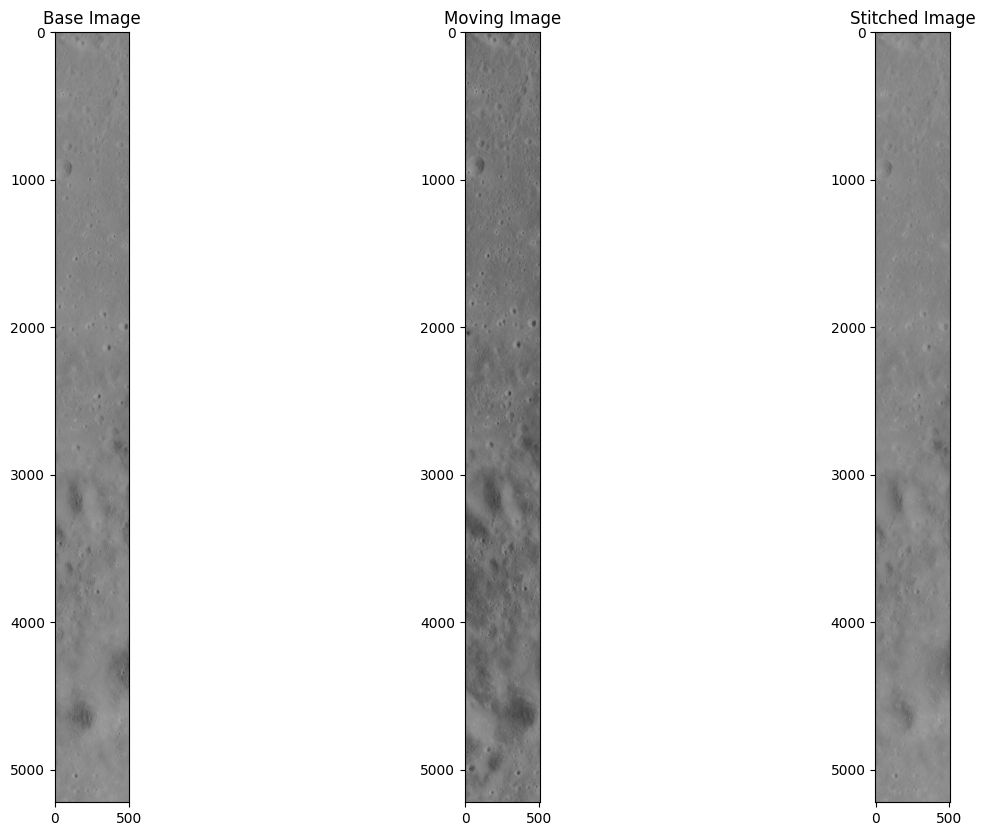

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import match_template
from skimage.transform import AffineTransform, warp
from skimage import img_as_ubyte

# Load the images
base_image = cv2.imread("image_2.jpg")
moving_image = cv2.imread("image_1.jpg")

# Convert images to grayscale
base_gray = cv2.cvtColor(base_image, cv2.COLOR_BGR2GRAY)
moving_gray = cv2.cvtColor(moving_image, cv2.COLOR_BGR2GRAY)

# Perform template matching
result = match_template(base_gray, moving_gray)
ij = np.unravel_index(np.argmax(result), result.shape)
top_left = ij[::-1]
height, width = moving_gray.shape

# Estimate the translation matrix
translation = (top_left[0], top_left[1])
transform = AffineTransform(translation=translation)

# Warp the moving image using the translation matrix
warped_image = warp(moving_image, transform.inverse, output_shape=(base_image.shape[0], base_image.shape[1]), mode='constant', cval=0)

# Convert the warped image to 8-bit format
warped_image_ubyte = img_as_ubyte(warped_image)

# Create a blank canvas to hold the stitched result
stitched_image = np.maximum(base_image, warped_image_ubyte)

# Display the images
plt.figure(figsize=(15, 10))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(base_image, cv2.COLOR_BGR2RGB))
plt.title('Base Image')
plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(moving_image, cv2.COLOR_BGR2RGB))
plt.title('Moving Image')
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(stitched_image, cv2.COLOR_BGR2RGB))
plt.title('Stitched Image')
plt.show()


In [9]:
result

array([[0.12946621]])

In [8]:
translation

(np.int64(0), np.int64(0))

In [6]:
stitched_image.shape

(5222, 506, 3)

In [7]:
moving_image.shape

(5222, 506, 3)